# Introduction
This is the Marginal Effects at Means portion of the project
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [1]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# DETERMINE IF YOU ARE USING RAW OR SCALED
Scaled is Zhao's data, continuous variables divided by standard deviation
<br>Raw is unscaled raw data

In [2]:
useSavedModel=True
filename_model_params = "RF_model_params.sav"
useRaw=False
outdir = 'outBElectionResultsScaled2'
filename='results.csv'
filename_all = 'results_complete.csv'
filename_model_params = "RF_model_params.sav"
os.makedirs(outdir, exist_ok=True)

# the dependant variable(s)
columns_dep_var= ['cc.TrumpGEVote','cc.TrumpPVote', 'cc.vote12.gop']

#get the data
if (useRaw == True):
    df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")
else:
    df = pd.read_csv('./data/ccesplus_fscaled.csv',encoding = "ISO-8859-1")

# Choose which dependant variable to operate on

In [3]:
dep_var = columns_dep_var[2]
dump_these_dep_var_columns=columns_dep_var.copy()
dump_these_dep_var_columns.remove(dep_var)
dep_var

'cc.vote12.gop'

## Get the columns of interest, including all dependent vars

In [4]:
all = pd.read_excel('./data/CCESplusVariables.xlsx',encoding = "ISO-8859-1")

# for every regid=3.1 get the third column (variable name) convert to a list
columns = list(all[ (all['regid']==1.1) & (all['exclude']!='t')  ].iloc[:,2])

# #strip dependant variables
# columns = [col for col in columns if col not in columns_dep_var]
# columns

In [5]:
#WARNING! 'cc.i.white.educhs not in df! No worries though 
#its correlated with composed of cc.maxeduc.hs and cc.WhiteDum
#so drop it
columns.remove('cc.i.white.educhs')

In [6]:
len(columns)
# columns

35

## Extract just those columns from orig dataframe

In [7]:
df = df[columns]

In [8]:
len(df.columns)

35

## Remove NaN dependent variable rows


In [9]:
def remove_dep_var_nan_rows(df, col_dep_var, dump_these_dep_var_columns ,silent = False):
    """
    parse df into rows where df.col_dep_var does not have NaNs, 
    df: dataframe to pull NaN rows out of
    col_dep_var: dependent variable
    dump_these_dep_var_columns: other dep_var columns that may be highly correlated with dep var
    """
    dftmp= df.copy()
    
    if(silent is False):
        print(f'dropping {(pd.isnull(dftmp[col_dep_var])).sum()} rows where {col_dep_var}=NaN')
                      
    #dump the NaN rows
    dftmp = dftmp[pd.notnull(dftmp[col_dep_var] )]
    
    #dump the dump_these_dep_var_columns
    dftmp.drop(dump_these_dep_var_columns,axis=1,inplace=True);
    
    return dftmp

# pull out the nulls from the column of interest
dftmp= remove_dep_var_nan_rows(df, columns_dep_var[0],dump_these_dep_var_columns )

dropping 23710 rows where cc.TrumpGEVote=NaN


In [10]:
#get a list of the columns to operate on minus the dependant variable
columns = dftmp.columns.drop(dep_var)
columns

Index(['cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc', 'rustpc',
       'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_2', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum',
       'cc.raceviewsum', 'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex',
       'cc.BlackDum', 'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.maxeduc.hs',
       'cc.isimmigrant', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.Ideo7',
       'cc.EvanProt', 'cc.Catholic', 'cc.Religiosity', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

## Split out categorical and continuous variables
see if fastai can auto do it

In [11]:
# #give fastai a shot at splitting cat and cont variables
res_cont, res_cat = cont_cat_split(dftmp,max_card=18)

## Categorify and Fill Missing

In [12]:
#from docs https://docs.fast.ai/tabular.transform.html
# tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
# tfm(dftmp)

In [13]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(dftmp)

## Generate train and test set

In [14]:
# split out train/test sets
from sklearn.model_selection import train_test_split

trn=tst=None
trn,tst = train_test_split(dftmp, test_size=0.1)
print(str(len(trn)))
print(str(len(tst)))

36801
4089


In [15]:
len(trn.columns)

33

In [16]:
#split out trn_y and tst_y
#this is the dep_var, converted to an int
trn_y = trn[dep_var].copy()
tst_y = tst[dep_var].copy()
trn_y.astype('int64');
trn_y.astype('int64');

trn.drop(dep_var,axis=1,inplace=True);
tst.drop(dep_var,axis=1,inplace=True);

# Train a RandomForest on all data

In [17]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics

if (useSavedModel):
    # load the model from disk
    m_rf = pickle.load(open(outdir+"/"+filename_model_params, 'rb'))
else:
    #create a random forest object
    m_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=5)

# m_rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=5)


In [18]:

def rmse(x,y): 
    '''this and R**2 used for continuous variables'''
    return math.sqrt(((x-y)**2).mean())

def print_score(m, trn, trn_y, tst, tst_y):
    '''
    
    '''
    res = [m.score(trn, trn_y), m.score(tst, tst_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

def eval_accuracy(preds,targs, silent=True):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    acc=100*matches/totals 
    if( silent == False):
        print(f"Got {matches} right out of {totals} samples, Accuracy is {acc} percent")
    return acc

In [19]:
#train the random forest 
m_rf.fit(trn, trn_y)
print_score(m_rf, trn, trn_y, tst, tst_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=999, verbose=0, warm_start=False)

[0.9145131925762887, 0.8745414526779164, 0.884622700470096]


In [20]:
#just another way to see stuff
# preds1 = m_rf.predict(tst)
# eval_accuracy(preds1,tst_y,silent=False);

In [21]:
columns

Index(['cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc', 'rustpc',
       'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_2', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum',
       'cc.raceviewsum', 'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex',
       'cc.BlackDum', 'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.maxeduc.hs',
       'cc.isimmigrant', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.Ideo7',
       'cc.EvanProt', 'cc.Catholic', 'cc.Religiosity', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

# Run multinomial regression to check regression accuracy

In [22]:
from sklearn.linear_model import LogisticRegression

#first with one verses rest
m_mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr',max_iter=10000)
m_mlr.fit(trn, trn_y)
print_score(m_mlr, trn, trn_y, tst, tst_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

[0.88413358332654, 0.880410858400587]


# Now run MEMs on columns of interest

In [23]:
#this directory contains symlink created at command line like this
# ln -s ../Marginal_Effects_at_Means ./Marginal_Effects_at_Means
#it allows this directory to find Marginal_Effects_at_Means, a directory 1 above this one
#this dir contains a file called mem.py which contains MEMs
from Marginal_Effects_at_Means.mem import MEMs

In [24]:
all = trn.copy().append(tst.copy(), ignore_index=True)
all_y = trn_y.copy().append(tst_y.copy(), ignore_index=True)

In [26]:
#RUN ON WHOLE DATASET OR JUST THE TestSET?  I'm thinking the whole dataset.  
# The model has some idea of how voters will vote based on the input features, lets use that knowledge
#to see what happens when we start changing variables
mems = MEMs(all)

In [27]:
#whats the average look like?
mems.df_avg

,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_2,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.maxeduc.hs,cc.isimmigrant,cc.child18,cc.union,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,demo.popdense,cc.RepDum,cc.IndDum
0,0.0449988,0.939681,0.933083,0.858774,0.720578,0.961365,0.970943,0.913281,0.634613,0.115309,0.963491,0.821114,0.936112,0.99909,0.507459,1.03422,0.550037,0.0972854,0.769748,0.249572,0.220054,0.1517,0.231719,0.282416,0.708198,0.917102,0.276791,0.223258,0.919964,0.260223,0.272878,0.260797


# Results: 
- For each column
    - If binary column generate results on average row with that col set to min() and then max()
    - If continuous column generate results on average row with that col set to average and then 1 std deviation above average

In [32]:
#linear regression
p=mems.getMEM_avg(m_mlr)
p

array([[0.814974, 0.185026]])

In [33]:
#random forest
p=mems.getMEM_avg(m_rf)
p

array([[0.94156, 0.05844]])

For the average case m_rf and m_mlr have significantly different predictions

In [34]:
def getMEM_CSV(m,mems,dep_var,df,type='_rf'):

    #The average prediction
    avpred = (mems.getMEM_avg(m))[0][1]

    #get all the columns we are going to run MEMs on
    cols = list(df.columns)
    cols.remove(dep_var)#dump dependant variable

    #for binary values, predict when col=0 then predict when col=1, output is probability vote for depvar
    #NOTE one of the 2 results below will look like the average from above since the reality is that these values only
    #take 1 of 2 values. So the model will treat them as 1 of the 2, not an average of all columns.
    #for continuous values, predict when col=average then predict when col is +1 standard deviation away
    #output is probability vote for depvar

    #what goes in csv
    colsr = ['column_name','aveage_val','initval','initval_predict_prob','finalval','finalval_predict_prob', 'final_minus_init']
    df_res = pd.DataFrame(columns = colsr)

    for col in cols:
        p=mems.getMEM_avgplusoneSimple(m, col)
        df_res = df_res.append({colsr[0]:col,colsr[1]:float(mems.df_avg[col]),colsr[2]:p[0][0],colsr[3]:p[0][1],
                                colsr[4]:p[1][0],colsr[5]:p[1][1],colsr[6]:(p[1][1]-p[0][1])},ignore_index=True )

#     df_res.head()
    filename = outdir+ "/MEMS_" + dep_var +type+ ".csv"
    
    with open(filename, 'w') as f:
        f.write(f'Prediction for the average column is {avpred}')
        df_res.to_csv(f,encoding = "ISO-8859-1")               

In [35]:
#firest for rf
getMEM_CSV(m_rf,mems,dep_var,dftmp)

In [36]:
#then for lr
getMEM_CSV(m_mlr,mems,dep_var,dftmp,type='_lr' )

# See what the difference is between lr and rf

In [37]:
res_rf= pd.read_csv((outdir+ "/MEMS_" + dep_var +"_rf.csv"),encoding = "ISO-8859-1")
res_lr= pd.read_csv((outdir+ "/MEMS_" + dep_var +"_lr.csv"),encoding = "ISO-8859-1")

In [38]:
res_rf

,Prediction for the average column is 0.05843982389652779,column_name,aveage_val,initval,initval_predict_prob,finalval,finalval_predict_prob,final_minus_init
0,0,cc.emp.nojob,0.044999,0.000000,0.058440,1.000000,0.059273,0.000833
1,1,cc.CC16_304,0.939681,0.939681,0.058440,1.939681,0.096678,0.038238
2,2,cc.faminc,0.933083,0.933083,0.058440,1.933083,0.098590,0.040150
3,3,crashpc,0.858774,0.858774,0.058440,1.858774,0.077118,0.018678
4,4,rustpc,0.720578,0.720578,0.058440,1.720578,0.069123,0.010683
5,5,job.uer,0.961365,0.961365,0.058440,1.961365,0.073354,0.014915
6,6,econ.mhi,0.970943,0.970943,0.058440,1.970943,0.069213,0.010773
7,7,econ.hhpov.p,0.913281,0.913281,0.058440,1.913281,0.065361,0.006921
8,8,taa.wrks.disc95.pcpy,0.634613,0.634613,0.058440,1.634613,0.067305,0.008866
9,9,cc.CC16_305_2,0.115309,0.000000,0.058440,1.000000,0.058173,-0.000267


In [39]:
res_lr

,Prediction for the average column is 0.1850257495431913,column_name,aveage_val,initval,initval_predict_prob,finalval,finalval_predict_prob,final_minus_init
0,0,cc.emp.nojob,0.044999,0.000000,0.184951,1.000000,0.186621,0.001670
1,1,cc.CC16_304,0.939681,0.939681,0.185026,1.939681,0.431551,0.246525
2,2,cc.faminc,0.933083,0.933083,0.185026,1.933083,0.270735,0.085709
3,3,crashpc,0.858774,0.858774,0.185026,1.858774,0.187108,0.002082
4,4,rustpc,0.720578,0.720578,0.185026,1.720578,0.168045,-0.016981
5,5,job.uer,0.961365,0.961365,0.185026,1.961365,0.167676,-0.017349
6,6,econ.mhi,0.970943,0.970943,0.185026,1.970943,0.198214,0.013188
7,7,econ.hhpov.p,0.913281,0.913281,0.185026,1.913281,0.211793,0.026768
8,8,taa.wrks.disc95.pcpy,0.634613,0.634613,0.185026,1.634613,0.196016,0.010991
9,9,cc.CC16_305_2,0.115309,0.000000,0.184460,1.000000,0.189413,0.004954


In [61]:
res_lr.head()
res_lr.describe()

,Prediction for the average column is 0.1850257495431913,column_name,aveage_val,initval,initval_predict_prob,finalval,finalval_predict_prob,final_minus_init
0,0,cc.emp.nojob,0.044999,0.000000,0.184951,1.000000,0.186621,0.001670
1,1,cc.CC16_304,0.939681,0.939681,0.185026,1.939681,0.431551,0.246525
2,2,cc.faminc,0.933083,0.933083,0.185026,1.933083,0.270735,0.085709
3,3,crashpc,0.858774,0.858774,0.185026,1.858774,0.187108,0.002082
4,4,rustpc,0.720578,0.720578,0.185026,1.720578,0.168045,-0.016981


,Prediction for the average column is 0.1850257495431913,aveage_val,initval,initval_predict_prob,finalval,finalval_predict_prob,final_minus_init
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,15.500000,0.585808,0.452870,0.180847,1.452870,0.257839,0.076992
std,9.380832,0.343109,0.452753,0.017358,0.452753,0.144177,0.152282
min,0.000000,0.044999,0.000000,0.107157,1.000000,0.059353,-0.147390
25%,7.750000,0.257560,0.000000,0.184828,1.000000,0.177990,-0.012362
50%,15.500000,0.671406,0.447418,0.185026,1.447418,0.194249,0.012089
75%,23.250000,0.923244,0.923244,0.185026,1.923244,0.282924,0.097898
max,31.000000,1.034222,1.034222,0.206743,2.034222,0.729274,0.544248


In [62]:
res_rf1 = res_rf[['column_name','final_minus_init']]
res_lr1 = res_lr[['column_name','final_minus_init']]


In [63]:
res_rf1.describe()

,final_minus_init
count,32.000000
mean,0.042902
std,0.097815
min,-0.020722
25%,0.002869
50%,0.010728
75%,0.036712
max,0.477615


In [64]:
vals1 = pd.DataFrame(data=(res_rf1['column_name']))
f2 = (res_rf1['final_minus_init'] - res_lr1['final_minus_init']).to_frame()
# vals1.merge(((res_rf['final_minus_init'] - res_lr['final_minus_init'])).to_frame())

In [65]:
vals1=pd.merge(vals1,f2,left_index=True, right_index=True);

In [66]:
vals1.columns

Index(['column_name', 'final_minus_init'], dtype='object')

In [67]:
# vals1.merge(f2)
vals1.sort_values(by=['final_minus_init'], inplace=True)
vals1

,column_name,final_minus_init
25,cc.Ideo7,-0.273052
15,cc.Age,-0.243703
1,cc.CC16_304,-0.208287
13,cc.CC16_307,-0.206450
12,cc.raceviewsum,-0.161670
31,cc.IndDum,-0.096483
11,cc.immviewsum,-0.091116
28,cc.Religiosity,-0.047267
2,cc.faminc,-0.045558
18,cc.WhiteDum,-0.024555


In [77]:
cols = ['cc.Ideo7','cc.Age','cc.CC16_304','cc.CC16_307','cc.raceviewsum','cc.IndDum','cc.Religiosity']
res_lr2 = res_lr[(res_lr['column_name'].isin(cols)) ]
res_rf2=res_rf[(res_lr['column_name'].isin(cols))]

cols_keep =['column_name','initval','initval_predict_prob','finalval','finalval_predict_prob','final_minus_init']
res_lr2[cols_keep]
res_rf2[cols_keep]

,column_name,initval,initval_predict_prob,finalval,finalval_predict_prob,final_minus_init
1,cc.CC16_304,0.939681,0.185026,1.939681,0.431551,0.246525
12,cc.raceviewsum,0.936112,0.185026,1.936112,0.482050,0.297025
13,cc.CC16_307,0.999090,0.185026,1.999090,0.417792,0.232766
15,cc.Age,1.034222,0.185026,2.034222,0.472816,0.287790
25,cc.Ideo7,0.917102,0.185026,1.917102,0.729274,0.544248
28,cc.Religiosity,0.919964,0.185026,1.919964,0.273117,0.088091
31,cc.IndDum,0.000000,0.136392,1.000000,0.388411,0.252018


,column_name,initval,initval_predict_prob,finalval,finalval_predict_prob,final_minus_init
1,cc.CC16_304,0.939681,0.05844,1.939681,0.096678,0.038238
12,cc.raceviewsum,0.936112,0.05844,1.936112,0.193795,0.135355
13,cc.CC16_307,0.999090,0.05844,1.999090,0.084756,0.026316
15,cc.Age,1.034222,0.05844,2.034222,0.102526,0.044087
25,cc.Ideo7,0.917102,0.05844,1.917102,0.329636,0.271196
28,cc.Religiosity,0.919964,0.05844,1.919964,0.099264,0.040824
31,cc.IndDum,0.000000,0.05844,1.000000,0.213975,0.155536


In [79]:
# vals['column_name']=res_rf['column_name']

# len(vals)

# Scratch

## Feature importance

In [80]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(m_rf, random_state=1).fit(tst, tst_y)
eli5.show_weights(perm, feature_names = tst.columns.tolist())

Weight,Feature
0.0533 ± 0.0077,cc.RepDum
0.0402 ± 0.0020,cc.Ideo7
0.0125 ± 0.0033,cc.raceviewsum
0.0112 ± 0.0024,cc.IndDum
0.0082 ± 0.0019,cc.immviewsum
0.0062 ± 0.0040,cc.Age
0.0033 ± 0.0042,cc.CC16_304
0.0019 ± 0.0008,cc.Religiosity
0.0012 ± 0.0026,cc.CC16_307
0.0011 ± 0.0022,cc.BlackDum


## Try SHAP importance

In [81]:
import shap

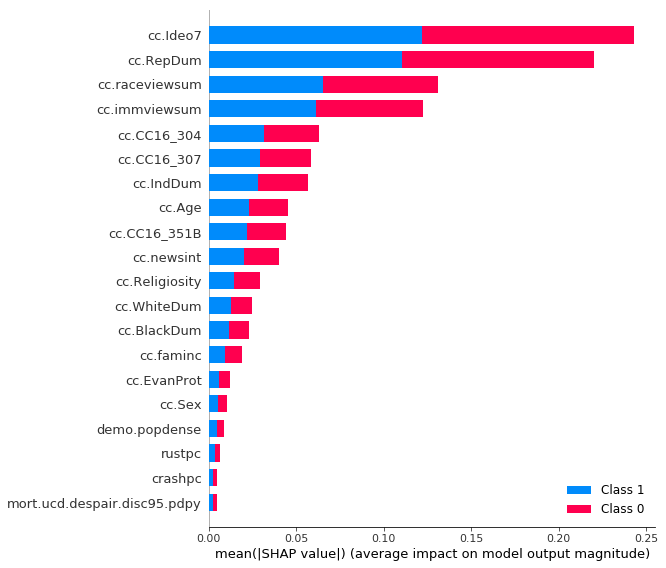

In [82]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(m_rf)
# shap_values = explainer.shap_values(trn)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], trn.iloc[0,:])

shap_values = explainer.shap_values(trn.sample(n=500))

shap.summary_plot(shap_values, trn, plot_type="bar")

cc.RepDum is highly correlated with predicted outcome 

In [85]:
from pdpbox import pdp
from plotnine import *

In [86]:
import matplotlib.font_manager
def plot_pdp(feat, m, x, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)


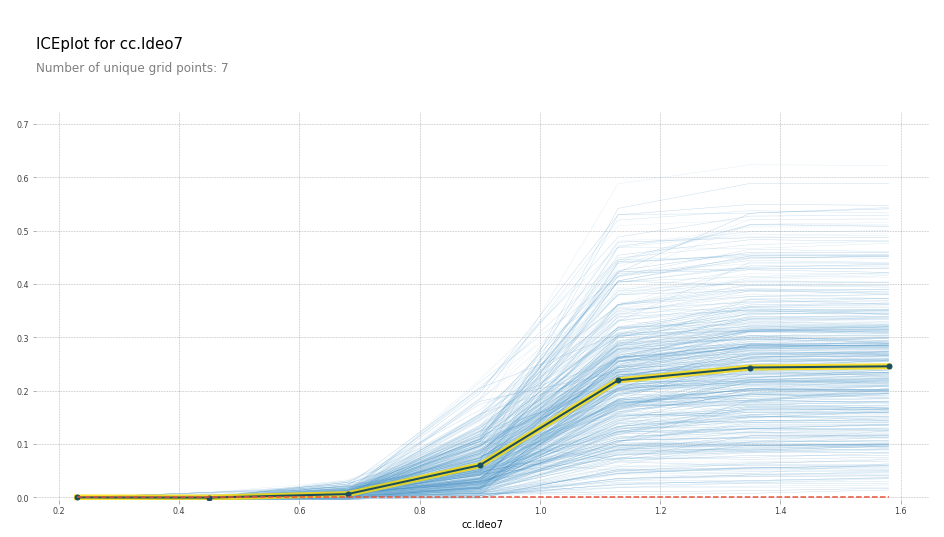

In [89]:
plot_pdp('cc.Ideo7', m_rf, trn[:500])

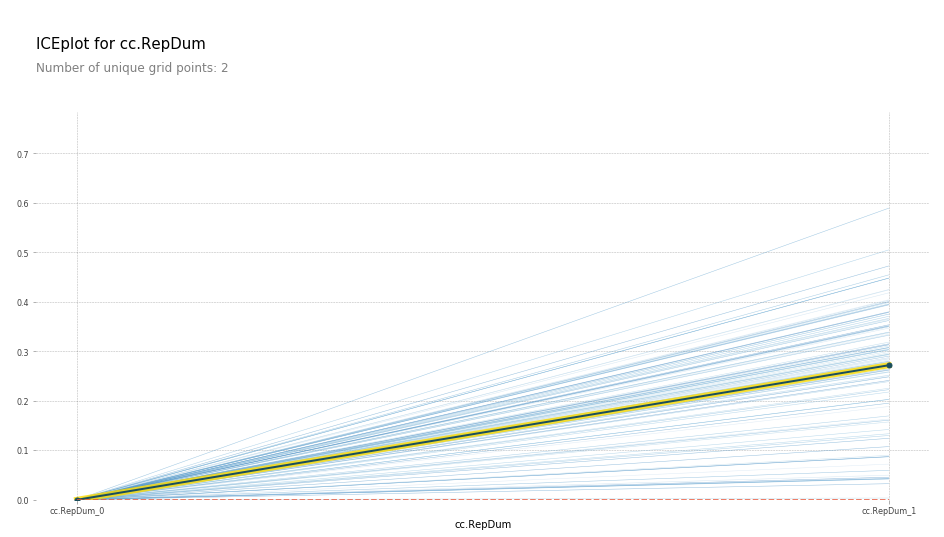

In [88]:
plot_pdp('cc.RepDum', m_rf, trn[:100])

/home/keith/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.

/home/keith/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.

/home/keith/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.



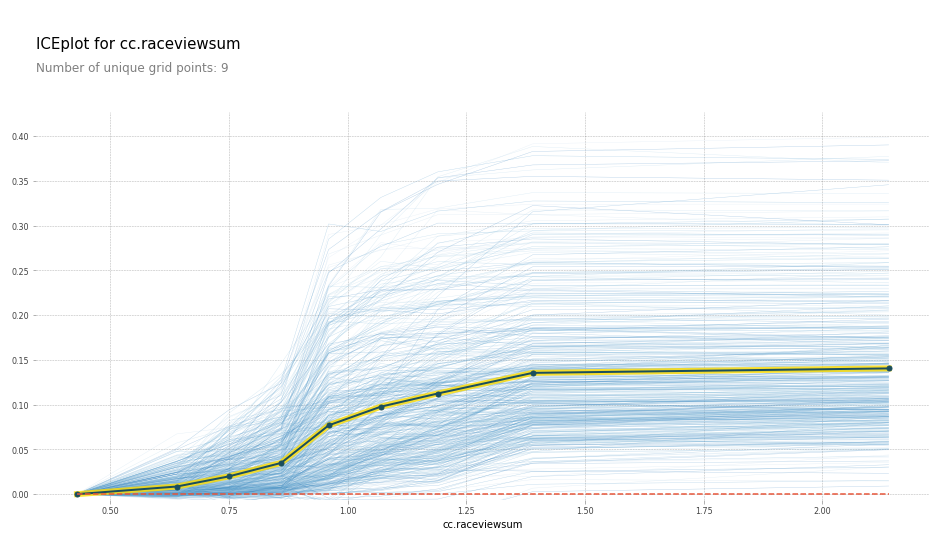

In [87]:
plot_pdp('cc.raceviewsum', m_rf, trn.sample(n=500))
# [(0.9361119104234529, array([[0.765415, 0.234585]])), 
#  (1.936111910423453, array([[0.583568, 0.416432]]))]

In [57]:
trn.columns

Index(['cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc', 'rustpc',
       'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_2', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum',
       'cc.raceviewsum', 'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex',
       'cc.BlackDum', 'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.maxeduc.hs',
       'cc.isimmigrant', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.Ideo7',
       'cc.EvanProt', 'cc.Catholic', 'cc.Religiosity', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

In [90]:
trn_high = trn[trn_y.iloc[:]==1.0]
trn_high

,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_2,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.maxeduc.hs,cc.isimmigrant,cc.child18,cc.union,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,demo.popdense,cc.RepDum,cc.IndDum
7508,0,0.947973,0.562184,0.486994,0.283530,0.997454,1.108232,0.867162,0.277401,1,1.172766,1.701138,1.176891,0.887577,1.0,1.063973,0,0,1,0,0,0,0.0,1.0,0.431581,1.353232,0.0,0.0,0.814553,0.087779,1.0,0.0
12364,1,0.631982,0.702731,0.694878,0.271416,1.138121,0.839497,1.070868,0.324173,1,1.175902,1.275854,1.390871,0.887577,1.0,0.945753,0,0,1,0,0,0,0.0,0.0,0.431581,1.353232,1.0,0.0,0.995565,0.134710,0.0,1.0
33400,0,1.263963,0.843277,0.792585,0.819449,0.860441,1.025846,0.654969,0.658121,0,0.823597,0.850569,0.962910,1.183436,0.0,0.512283,0,0,1,0,1,0,0.0,0.0,0.431581,1.353232,1.0,0.0,1.357588,0.230122,0.0,0.0
35266,0,0.947973,0.843277,1.463549,0.305406,1.329939,0.945028,0.952040,0.112670,0,0.998847,1.701138,0.748930,1.183436,0.0,0.926050,0,0,0,0,1,1,1.0,0.0,0.431581,0.902155,0.0,1.0,0.995565,0.057751,1.0,0.0
38452,0,1.263963,0.843277,0.995509,0.593426,1.101584,0.810803,1.645203,0.099390,0,0.801875,1.275854,1.283881,1.183436,1.0,1.398927,0,0,0,1,0,0,0.0,1.0,0.863162,1.127693,0.0,1.0,0.905059,4.210821,0.0,1.0
2702,0,1.263963,0.702731,0.731974,0.771484,1.033991,0.674548,1.236378,0.859421,0,0.889616,0.425285,1.176891,0.887577,0.0,1.418630,1,0,1,0,1,0,0.0,0.0,0.863162,1.578771,1.0,0.0,1.538600,0.016655,0.0,1.0
529,0,1.579954,1.405461,0.396202,0.735218,0.981012,1.008783,0.807748,0.584060,1,0.674326,1.701138,1.818831,1.183436,1.0,1.063973,1,0,1,0,0,0,1.0,0.0,0.431581,1.578771,1.0,0.0,1.357588,0.049636,0.0,1.0
32716,0,0.947973,1.264915,0.949781,0.540800,0.938995,0.813998,1.104819,0.438397,0,1.020915,1.701138,1.283881,1.183436,1.0,1.004863,0,0,1,0,0,0,0.0,0.0,0.431581,1.353232,0.0,1.0,1.086071,0.130856,1.0,0.0
59236,0,1.579954,0.983823,0.830555,0.879341,0.577281,0.998700,0.530483,0.614726,0,0.999999,1.275854,1.283881,0.887577,1.0,1.655068,0,0,1,0,0,0,0.0,0.0,0.431581,1.353232,0.0,0.0,1.267082,0.010082,0.0,0.0
49895,0,0.947973,0.983823,1.200590,0.491807,0.900632,0.760772,0.816236,0.670926,0,0.790200,1.701138,1.176891,1.183436,0.0,1.162489,1,0,1,0,0,0,0.0,1.0,0.863162,0.902155,0.0,0.0,1.448094,0.012475,0.0,0.0


In [91]:
#what is the average column
mems.df_avg

,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_2,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.maxeduc.hs,cc.isimmigrant,cc.child18,cc.union,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,demo.popdense,cc.RepDum,cc.IndDum
0,0.0449988,0.939681,0.933083,0.858774,0.720578,0.961365,0.970943,0.913281,0.634613,0.115309,0.963491,0.821114,0.936112,0.99909,0.507459,1.03422,0.550037,0.0972854,0.769748,0.249572,0.220054,0.1517,0.231719,0.282416,0.708198,0.917102,0.276791,0.223258,0.919964,0.260223,0.272878,0.260797


In [92]:
cols = mems.df_avg.columns
cols = list(cols)
cols

['cc.emp.nojob',
 'cc.CC16_304',
 'cc.faminc',
 'crashpc',
 'rustpc',
 'job.uer',
 'econ.mhi',
 'econ.hhpov.p',
 'taa.wrks.disc95.pcpy',
 'cc.CC16_305_2',
 'mort.ucd.despair.disc95.pdpy',
 'cc.immviewsum',
 'cc.raceviewsum',
 'cc.CC16_307',
 'cc.CC16_351B',
 'cc.Age',
 'cc.Sex',
 'cc.BlackDum',
 'cc.WhiteDum',
 'cc.maxeduc.4yr',
 'cc.maxeduc.hs',
 'cc.isimmigrant',
 'cc.child18',
 'cc.union',
 'cc.newsint',
 'cc.Ideo7',
 'cc.EvanProt',
 'cc.Catholic',
 'cc.Religiosity',
 'demo.popdense',
 'cc.RepDum',
 'cc.IndDum']

In [93]:
prob = m_rf.predict_proba(mems.df_avg)
prob
probb=m_rf

array([[0.94156, 0.05844]])

In [94]:
from eli5 import show_prediction
show_prediction(m_rf, trn_high.iloc[7],feature_names=cols, show_feature_values=True)
show_prediction(m_rf, mems.df_avg, feature_names=cols)
